In [3]:
import dynet as dy
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import simple_nns as sn

%matplotlib inline

In [25]:
%load_ext autoreload
%autoreload 2  # ensures seamless reload of any changed module

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
seaborn.set()

### The Curiosity
I was intrigued by some questions regarding MLP's and their application to classification problems. I was further intrigued by the fact that most contemporary online sources regarding neural networks and MLP's don't discuss them. While these questions are not the direct topic of the work below, they form the "curiousity framework" for it (words are emphasized to improve readability of long sentences):

1. Why is it a common practice to use **long (100+ element) vectors in MLP hidden layers** even when the training dataset is not big (tens of thousands cases)? aren't smaller spaces enough for classification, especially when the number of output classes is smaller (2-5)?
1. How to tell if the **dimension** I chose in my MLP design for the hidden layer(s) **is too big or too small**? 
1. In a multi-layer MLP, Can the successive application of linear transformations and nonlinear 'activations' be made better understood?
1. How to tell if the **MLP converged to a "reasonable" solution** given the training set?
1. Splitting out labeled data into train and "dev" sets (the latter not used for training) can be problematic if the size of labeled data set is barely enough for effective training. Are there **alternate approaches to examining** (and controling) **the generality of the resulting model**?
1. **regularization** - what is the correct approach to adding regularization terms?
1. Is there an **alternative training process to SGD**, even a much less efficient one, that can be used to validate an SGD training result?
1. Under what conditions (and assumptions on the underlying data distribution) can the output vector of a (multi-layer) MLP be interpreted as **a maximum likelihood estimate of the probabilities** of the various classes? 

While I am not sure to what extent these questions have or have not been answered, reaching insights in areas where they were lacking, will be greatly appreciated by many NN practitioners.


### Gaining (provisional) understanding of an MLP layer
Understaning something complex always starts with a simplistic model, (but not too simplistic - barrowing from [Einstein's famous quote](https://www.brainyquote.com/quotes/albert_einstein_103652)).

In the next few short sections I will go over the choices I made to start analyzing MLPs - choosing an activation function, a loss function and layer configuration that (I believe) are conceptually simpler without compromising important concepts and the overall structure. 

### The $\tanh$ devolved: the Double ReLU or `drel`
Here's a (humorous) thought experiment: what would $\tanh$ look like if you needed to represent it using '70s-era electronic hardware?  

Equivalent question: what's a good piecewise-linear approximation of the $\tanh$? answer:
a 3-piece curve, which could be conceived as two-sided ReLU (rectified linear unit). I called it ``drel`` (for Double RELu)

Since Dynet doesn't provide the $\max$ function directly, the simplest way to construct it is, indeed as a composite of two ReLUs, one of them flipped around the y axis.

Below is numpy code illustrating how to obtain `drel` from `relu`. Similar code using dynet's corresponding expression objects was used when constructing the actual networks below.

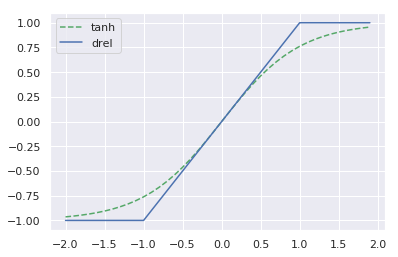

In [90]:
def relu(x):
    return np.maximum(0,x)
    
def drel(x):
    return -relu(-relu(x+1)+2)+1

x = np.arange(-2,2, 0.1)
y1 = np.tanh(x)
y2 = drel(x)
plt.plot(x,y1, 'g--', x, y2, 'b-')
plt.legend(['tanh', 'drel'])

### from log-loss to a quadratic goal
Here's the thing with log loss: it only cares about _one_ coordinate for every sample in the MLP's output (the one that represents the correct class). When we feed the log-loss with normalized vectors, such as those coming from a softmax, the fact that the elements are guaranteed to sum to 1 is enough to make this work well. If we compare one coordinate with 1, we effectively compare the rest with 0.

But if (for some crazy reason) we [refuse to go with the flow and use softmax](https://arxiv.org/abs/1511.05042) (or a similar normalizer) for our final layer (or our only layer, for a basic one-layer MLP), the log-loss breaks down: you can completely fool it with vectors of all-ones. In the typical case where each train sample is labeled by a single class, the all-one vectors are guaranteed to have zero loss, regardless of which classes they belong to!

The main reason for rejecting the softmax activation + cross-entropy measure for the subsequent analysis is that it's complicated, i.e. not geometrically intuitive. Another reason is that we want to explore the workings of hidden layers, not just the final layer. We may expand our model/explanation and deal with softamx later. For now, we want a more intuitive penalty term we can use during training of the MLP which will "guide" it towrads the correct output. The correct output of course is a "one hot" vector. In the two-class case it's either $[1. ,0.]$  or $[0., 1.]$. So... how about plain old Euclidean distance???

Let's look at the following pseudo-code:
```python
def eval_single_sample_loss(case_x, case_class):
    """
    @param case_x: the input vector for a sample
    @param case_class: the true class (as an integer)
    """
    output = evaluate_network(case_x) # run the MLP
    y_param = dy.vecInput(2)
    y_param.set(one_hot(2,case_class))
    loss = dy.squared_distance(output, y_param)
    return loss
```

That's it. If the output is not $[1., 0.]$ for a sample input vector from the 1st class, the MLP may still prediction predict the correct class for the sample (the predicted class is determined as usual using $\textrm{argmax}$). But it's not perfect, meaning the loss will not be zero. the loss penalty will only be 0 if the MLP outputs exactly $[1., 0.]$.

Squared distance is used as an objective in many classification/optimization problems, including linear regression and SVM. The SVM formulation is quite different, though: There, we _maximize_ the distance of _a single plane_ from the sample points (in feature space). The classification task is then carried out by outputting a scalar y, and using $\textrm{sign}(y)$  to determine the predicted class. That wouldn't work in our case (and doesn't generalize well to multi-class cases). The combination of a multi-dimensional output space and employing the Euclidean distance as a measure is therefore more flexible and more suitable for our purposes than the SVM formulation.



### Some (conceptual) results of the drel activation + Euclidean loss model

We'll now look at some geometric properties of an MLP with `drel` as the activation function, and Euclidean distance as formulated above. Some of these comments may seem at first to assume $w$ is square (since they use linear algebra term non-strictly), but have pretty straightforward extensions to non-square layer matrices. No proofs are provided, some details are provided where necessary.

* **An MLP with the `drel` function in the output can only output bounded vectors $v \in [-1,1]^{d}$**
* These vectors are points in a hypercube centered at the origin with sides of length 2.
* A perfect classification is where all input (train) points are mapped to a point of the form $[0,..,0,1,0,...0]$ (the location of the "1" corresponding to the correct class). These points are the centers of the positive faces of the hypercube. They are also the intersection points of the axes with the (positive) faces of the cube.
* For each layer of the MLP, which consists of an [affine transformation](https://en.wikipedia.org/wiki/Affine_transformation) followed by `drel` activation function: 
    * Points mapped by the linear stage to outside the hypercube, will have their "infringing" coordinates (i.e. those with $|v| > 1$), set to $\pm1$ by the activation function. In other words, they will snap to the boundary of the cube. They may be snapped to a face, edge, or corner, depdending on whether 1, 2 to d -1, or all d cooridnates were outside the bound following the affine transformation. 
    * Points outside the cube will have zero partial derivative in the directions of infringement, despite having a positive (and possibly large) loss. To illustrate the effect of this in the extreme case, imagine a one-layer MLP, with all the training data vectors $v^k, k\in[1..N]$ having all their coordinates in the zero-gradient zone: $|v^k_i| > 1,\forall k, i$ ($ i\in[1..d]$). Let's further assume that W is initially set to the identity matrix and the  bias term is set to zero. Then, despite the loss being potentially very large, the gradient for each sample will be zero in every direction, and the MLP will never converge to a solution. This "calamity" is easily avoided by pre-scaling the input and imposing suitable constraints on the [scaling component](https://en.wikipedia.org/wiki/Singular_value_decomposition) of the initial transformation matrices.
    * During training, assuming learning rate is small enough, a sample point will never generate a gradient in a direction that will push it outside the bounding box. However, a point close to the boundary may get "pushed" outside due to the application of a discrete (i.e. non-infitessimal) gradient-descent step and due to updates applied to $w$ and $b$ based on other points. A fraction of points being pushed to outside the cube is not a problem. These points will get mapped back to the boundary by the activation function and will therefore continue to "participate" in the gradient descent process.
    * Having some points go outside the bounding box (and be snapped back by the nonlinearity) is not only allowable, it is essential to solve nonlinear classification problems: If none of the points are mapped to outside the box by a layer, then the activation function of that layer has input=output, and the layer is purely linear*. This means the layer could be merged with the next one by replacing the next layer's transformation matrix with the multiplication of the two matrices. If none of the layers "engage" their activation function, then the MLP, even if it has several layers, is just a linear transformation.
 
\* from here on I will use "linear" and "affine" interchangeably.<p>


for gaining better understanding we will start with the simplest possible form of the classification MLP: a single layer MLP taking 2-D input and yielding 2-D output. This will allow direct visualization of the entire problem: the inputs, the transformation, and the transformed output.


### MLP convergence process illustration
To illustrate a classification problem we need input examples. Rather than real-world examples, I use synthetically generated input. This will allow us greater control and greater understanding. We'll assume our input data appears in patches, or clusters; the patches are circular, which can be thought of as modeling a "correct" or "true" location (the center of the circle) plus "noise" causing a scattering of the actual samples around the center. We will refer to these circle-centers as centroids. 

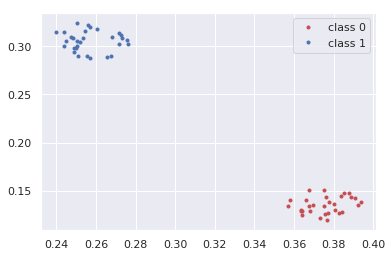

In [8]:
def unit_circle(phi):
    return np.array([np.cos(phi), np.sin(phi)])

specs = [
    sn.patch_train_data.patch_spec(unit_circle(20*np.pi/180)*0.4,0.02, 30, 0),
    sn.patch_train_data.patch_spec(unit_circle(50*np.pi/180)*0.4,0.02, 30, 1)
]

train_2patch = sn.patch_train_data(specs)

train_2patch.plot()
del specs

In [36]:
def demonstrate_convergence(train, k=7, g=3, with_bias=False, epochs_per_plot = 50, nn= None):
    assert(k <= g*g)
    plt.subplots(g,g,figsize=(20,20))
    plt.subplot(g,g,1)
    if nn:
        n1 = nn
    else:
        n1 = sn.single_layer(with_bias = with_bias)
    train.plot()
    n1.plot_2d_layer()
    plt.plot([0,0],[0,0],'k+')
    
    for i in range(2,k+1):
        n1.train_network(train.data(), epochs_per_plot)
        ax = plt.subplot(g,g,i)
        ax.set_title('{} epochs'.format((i-1)*epochs_per_plot))
        train.plot()
        n1.plot_2d_layer()
        plt.plot([0,0],[0,0],'k+')
    

    x_p = n1.eval_list(train.data_x)
    transformed_train_data = sn.train_data(x_p, train.data_y)
    ax = plt.subplot(g,g,k+1)
    ax.set_title('Transformed sample')
    transformed_train_data.plot()
    plt.plot([0,0],[0,0],'k+')
    


## Illustrating convergence 
### Convergence with zero bias
We construct a single-layer MLP. We use the two-patch training data above as input. We sample the state of $w$ every 50 epochs. The problem has a near-optimal solution. We expect it to reach the linear solution, where $w$ transforms the center of blue patch to $[1,0]$ and the center of the red patch to $[0,1]$. In order to see, on the original coordinates, where $w$ transforms to, it is more illustrative to plot the two $w^{-1}$ column vectors and view them as the basis of the transformed coordinate system.

#### initialization of $w$ and $b$: 
* The default init of $w$ and $b$ may result in values $ >> 1$ in their entries.
* Since the $\textrm{dReLU}$ function has zero gradient outside $\pm1$, The sample coordinates would (partially or fully) fall in the zero gradient zone.
* As discussed above, this would make SGD progress in the correct direction much harder.
* using a uniform-probability initialization that ensured $|w| \lt 1$, $|b| \lt 1$ solved this issue



average loss: 0.462243749549 acc: 0.789333333333
average loss: 0.241134154541 acc: 1.0
average loss: 0.111503283807 acc: 1.0
average loss: 0.0373616243586 acc: 1.0
average loss: 0.0084559788499 acc: 1.0
average loss: 0.00301696634138 acc: 1.0


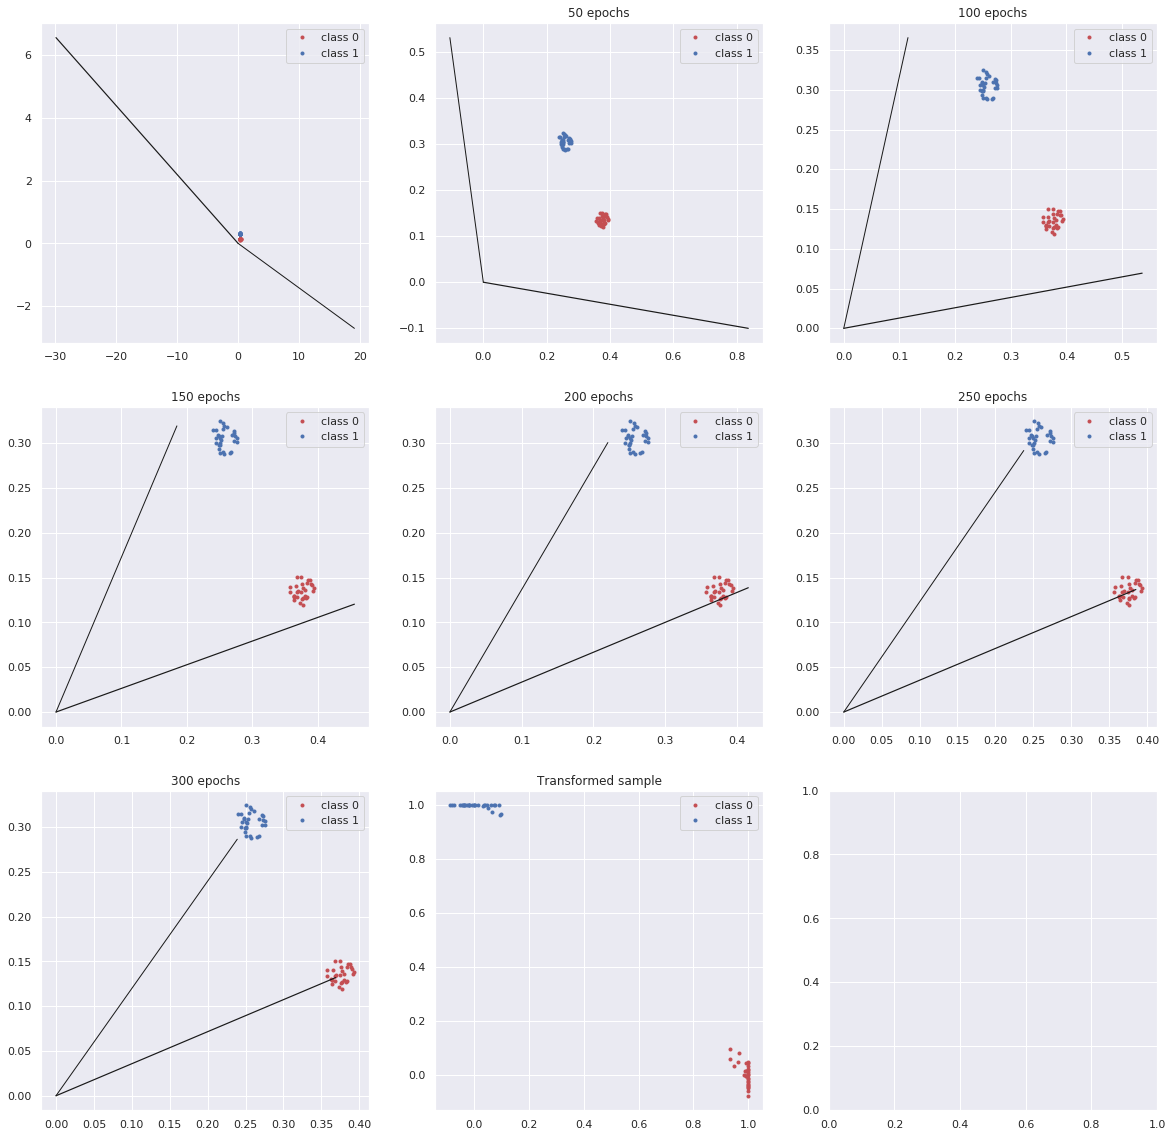

In [21]:
demonstrate_convergence(train_2patch, 7, 3, False)

What we see above is as follows:
* Top left: The initial $w$ has entries smaller than one (hence $w^{-1}$ showing very long basis vectors). Note the axes have different scales.
* Every additional plot shows the basis vectors rotating towards their patches and shrinking (i.e. $w$ entries getting larger)
* After 300 epochs, the vectors pointto the closer side of the blue patch, and roughly the center of the red patch.

* The final plot (bottom middle) shows the output coordinates of all the blue and red dots. They are very tightly arranged near their correct points. The nonlinearity helped "squash" the patch from a circular shape to a line. The reason that the length of the basis vectors matches the location of the patches is that :
    * axis vectors longer than that would mean the transformed dots have coordinate smaller than one in the class direction
    * axis vectors shorter than that would mean the lateral erros of the other class would increase.  

Running the sequence again, we see a very similar convergence process:

average loss: 0.589400893867 acc: 0.532333333333
average loss: 0.30286747473 acc: 1.0
average loss: 0.15366919621 acc: 1.0
average loss: 0.0617680972939 acc: 1.0
average loss: 0.0181857418649 acc: 1.0
average loss: 0.00519779540731 acc: 1.0


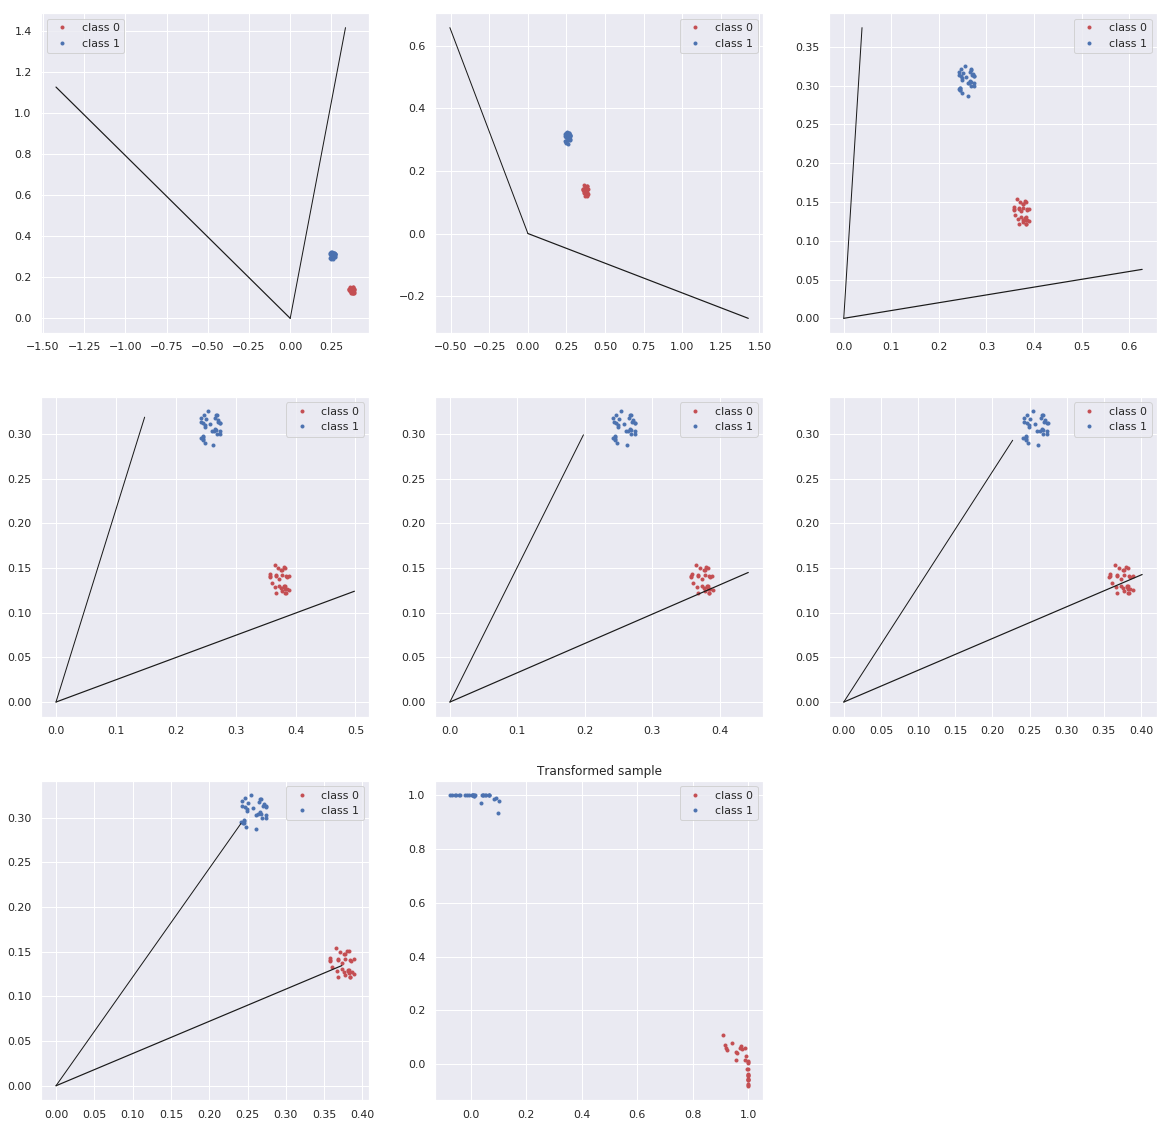

In [82]:
demonstrate_convergence(train, 7, 3, False)

### convergence in the presence of a bias term
* The bias term was added as $$output = \textrm{dReLU}(w \cdot (x + b))$$

* This formulation has more free parameters than necessary for this simple problem. Moreover,  a suitable $w$ can be found for almost any choice of $b$. Indeed, this MLP seems to converge slower than the bias-less formulation.

* The fact that $b$ is *inside* the parentheses (and therfore multiplied by $w$ together with $x$) makes the layer's transformation effect more intuitive:
    * We first _shift_ the coordinates by $b$ 
    * then apply $w$ - which may rotate, scale, shear them, etc. 

* It is easy to see the equivalence with the common formulation $w \cdot x + b'$ via $b'= w^{-1}b$.

    * However this relation is not numerically stable when $w$ is not [well-conditioned](https://en.wikipedia.org/wiki/Condition_number#Matrices), and therefore claiming (numerical) equivalence needs to be further substantiated.
    
* Also note that if W were not square, this formulation would have $b$'s dimension as the output of the *previous* layer, not the current one.



average loss: 0.458462338795 acc: 0.810333333333
average loss: 0.168012352875 acc: 1.0
average loss: 0.0225976191202 acc: 1.0
average loss: 0.0040781241712 acc: 1.0
average loss: 0.00357807914405 acc: 1.0
average loss: 0.00354235837814 acc: 1.0


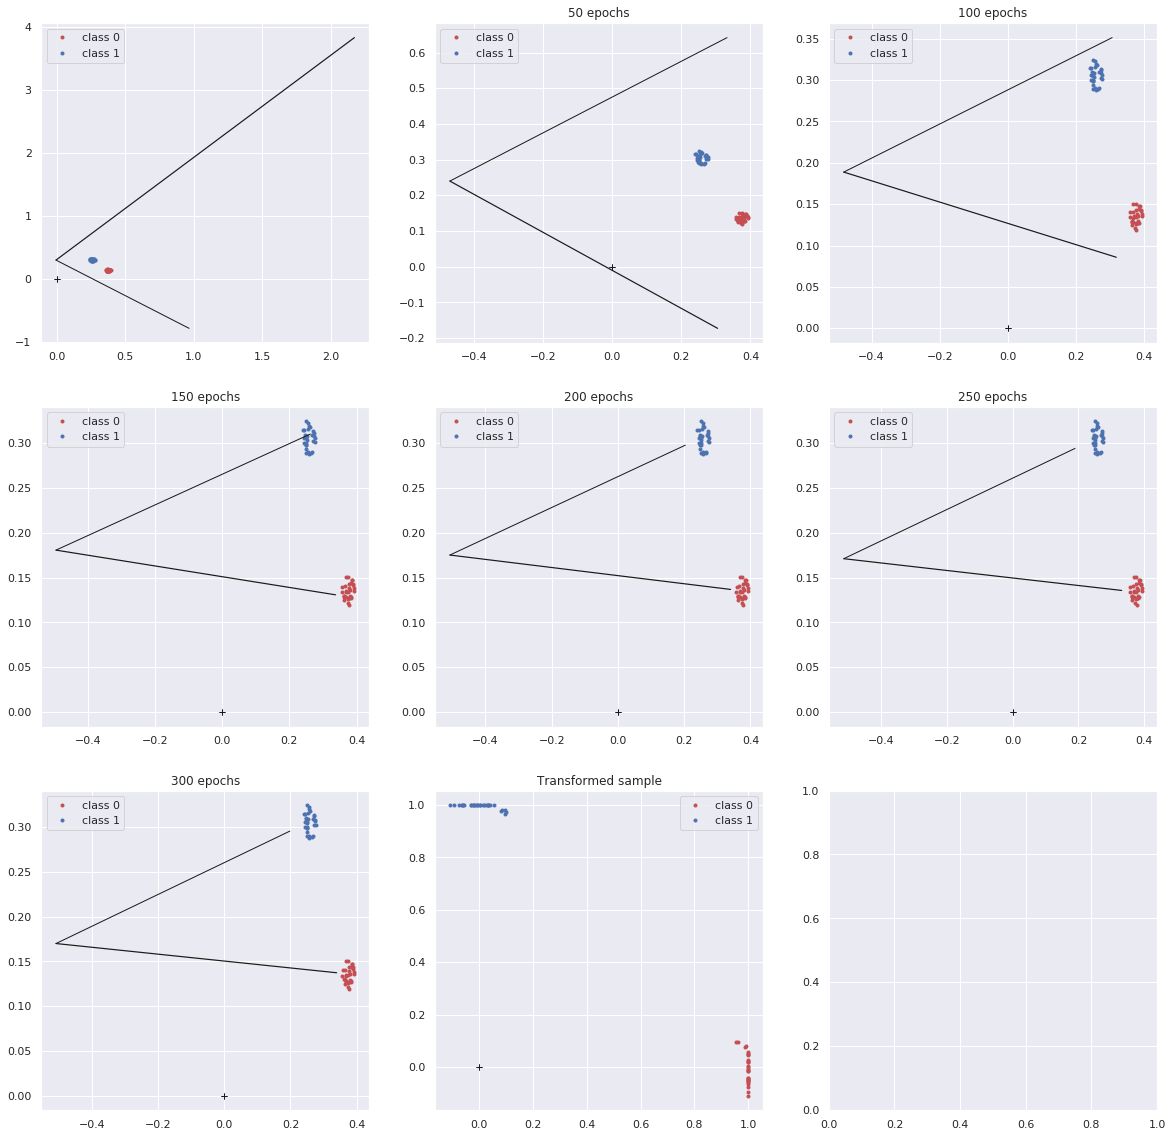

In [29]:
demonstrate_convergence(train_2patch, 7, 3, True)

average loss: 0.482768336574 acc: 0.816
average loss: 0.330401550169 acc: 1.0
average loss: 0.239457499062 acc: 1.0
average loss: 0.164627719842 acc: 1.0
average loss: 0.104999892555 acc: 1.0
average loss: 0.0606505968062 acc: 1.0


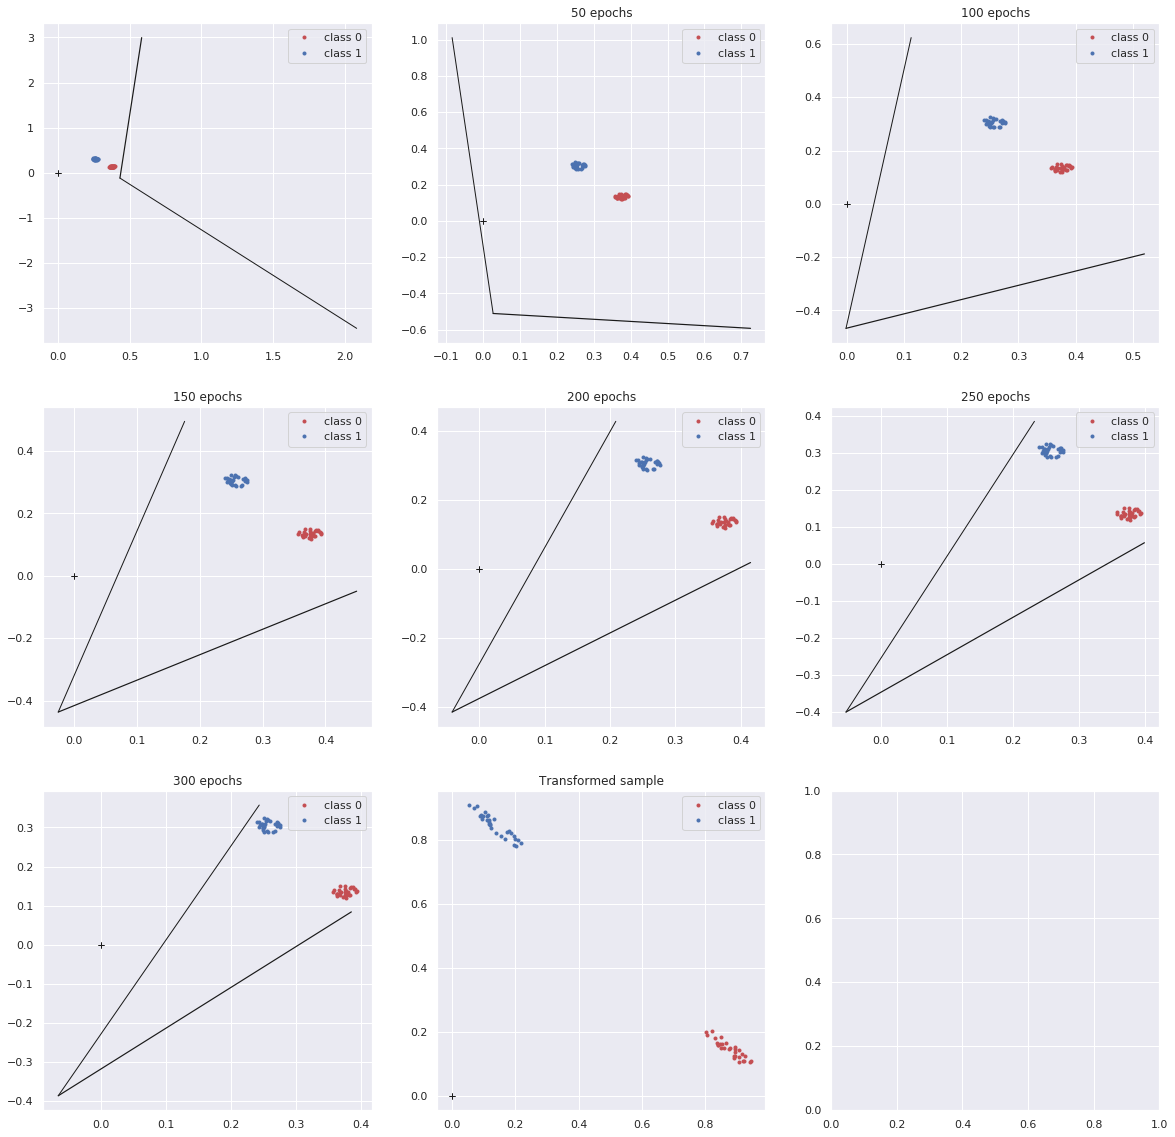

In [30]:
demonstrate_convergence(train_2patch, 7, 3, True)

average loss: 0.570510871838 acc: 0.375
average loss: 0.401766579668 acc: 1.0
average loss: 0.305138542747 acc: 1.0
average loss: 0.227503085668 acc: 1.0
average loss: 0.164283340516 acc: 1.0
average loss: 0.114254594608 acc: 1.0


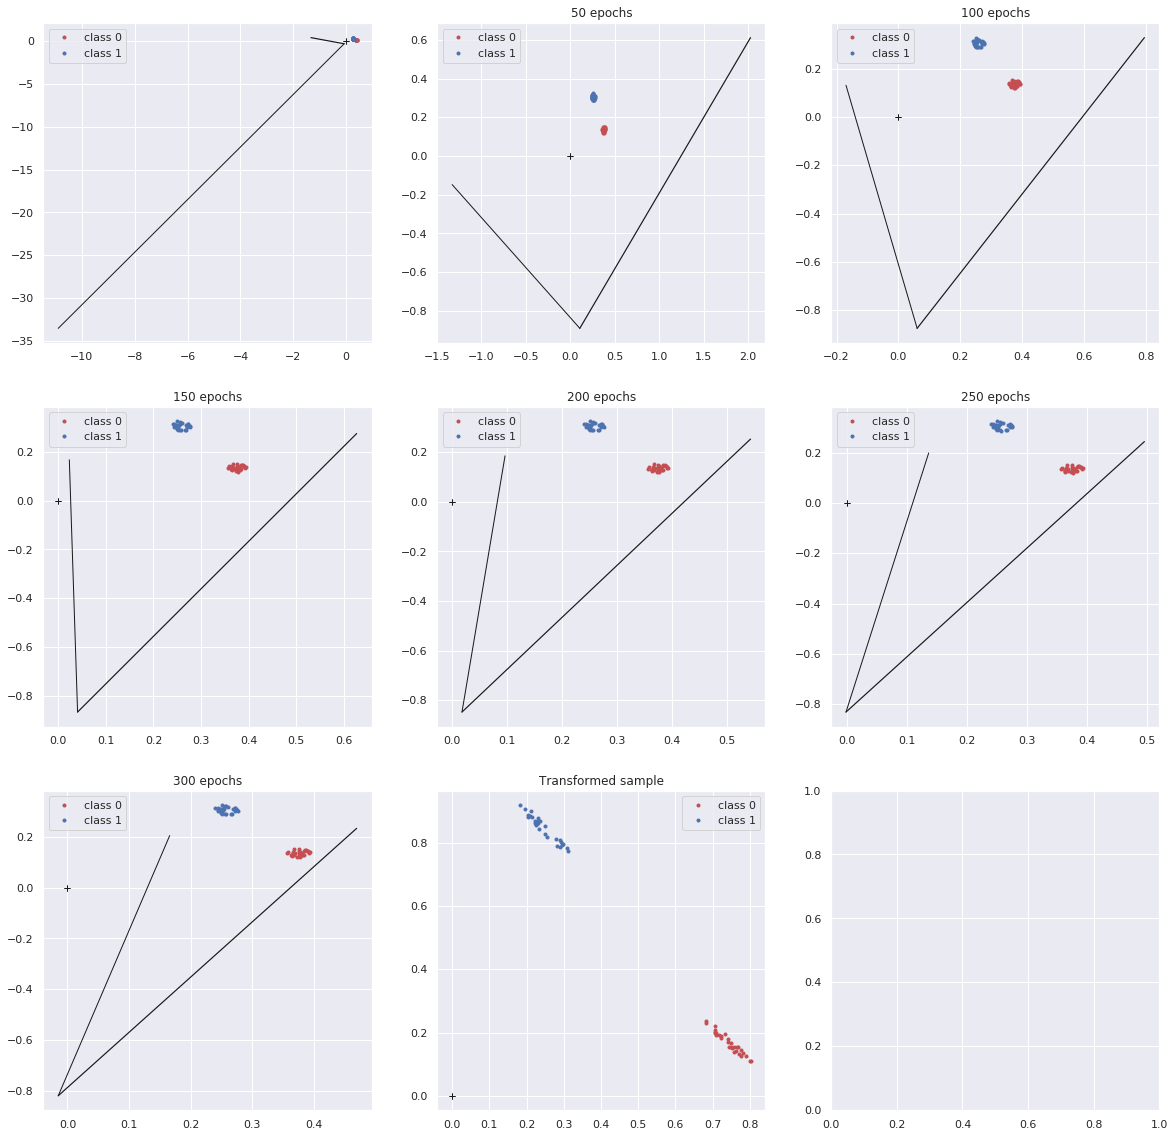

In [31]:
demonstrate_convergence(train_2patch, 7, 3, True)

We see that training the bias term and the transformation matrix doesn't help reach a solution faster in this case.

### using the bias term to solve "colinearity"
* Colinearity for our patch (clustered) training data means that more than 2 patches are on the same straight line
* if the extreme patches are of different classes, then 100% accuracy can still be obtained by placing the origin outside the straight line
* to examine the ability of the MLP to overcome this issue, we will initiate $b$ with zeros

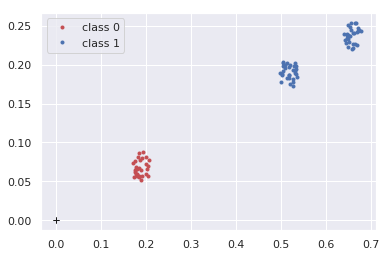

In [42]:

specs = [
    sn.patch_train_data.patch_spec(unit_circle(20*np.pi/180)*0.2,0.02, 30, 0),
    sn.patch_train_data.patch_spec(unit_circle(20*np.pi/180)*0.55,0.02, 30, 1),
    sn.patch_train_data.patch_spec(unit_circle(20*np.pi/180)*0.7,0.02, 30, 1),
]

train_3patch = sn.patch_train_data(specs)

train_3patch.plot()
plt.plot([0,0],[0,0],'k+' )
        
del specs

average loss: 0.252194340482 acc: 0.854666666667
average loss: 0.0536107802177 acc: 1.0
average loss: 0.0218627847726 acc: 1.0
average loss: 0.0207716070569 acc: 1.0
average loss: 0.0207515937136 acc: 1.0
average loss: 0.0207360509525 acc: 1.0


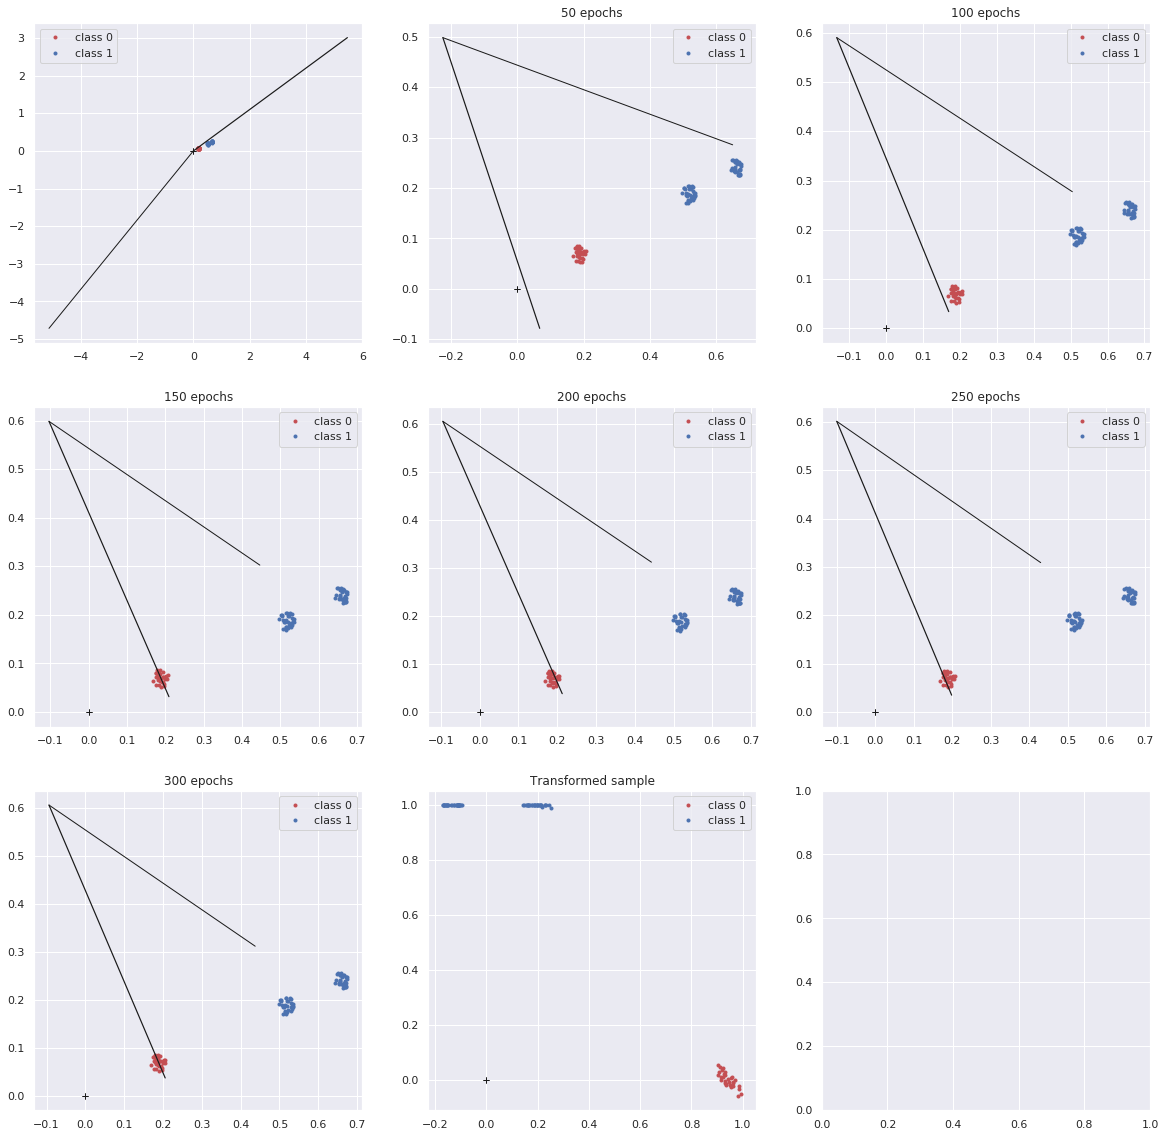

In [38]:

n1 = sn.single_layer(True)
# replace the default bias with our own, zero init
n1.params["b"] =  [n1.pc.add_parameters(2, name='b0', init = np.zeros(2, np.double))]

demonstrate_convergence(train_3patch, nn=n1)

del n1

Convergence occurred after less than 100 epochs. The length of the basis vector pointing to the  blue patches is limited by the fact that a longer vector would make the lateral locations of the blue patches more distant from $[0,1]$. 


Let's run the same problem again, different random W initialization:


average loss: 0.163599489088 acc: 0.917111111111
average loss: 0.0214839102768 acc: 1.0
average loss: 0.0205007406234 acc: 1.0
average loss: 0.02050677261 acc: 1.0
average loss: 0.0205405784019 acc: 1.0
average loss: 0.0204556997892 acc: 1.0


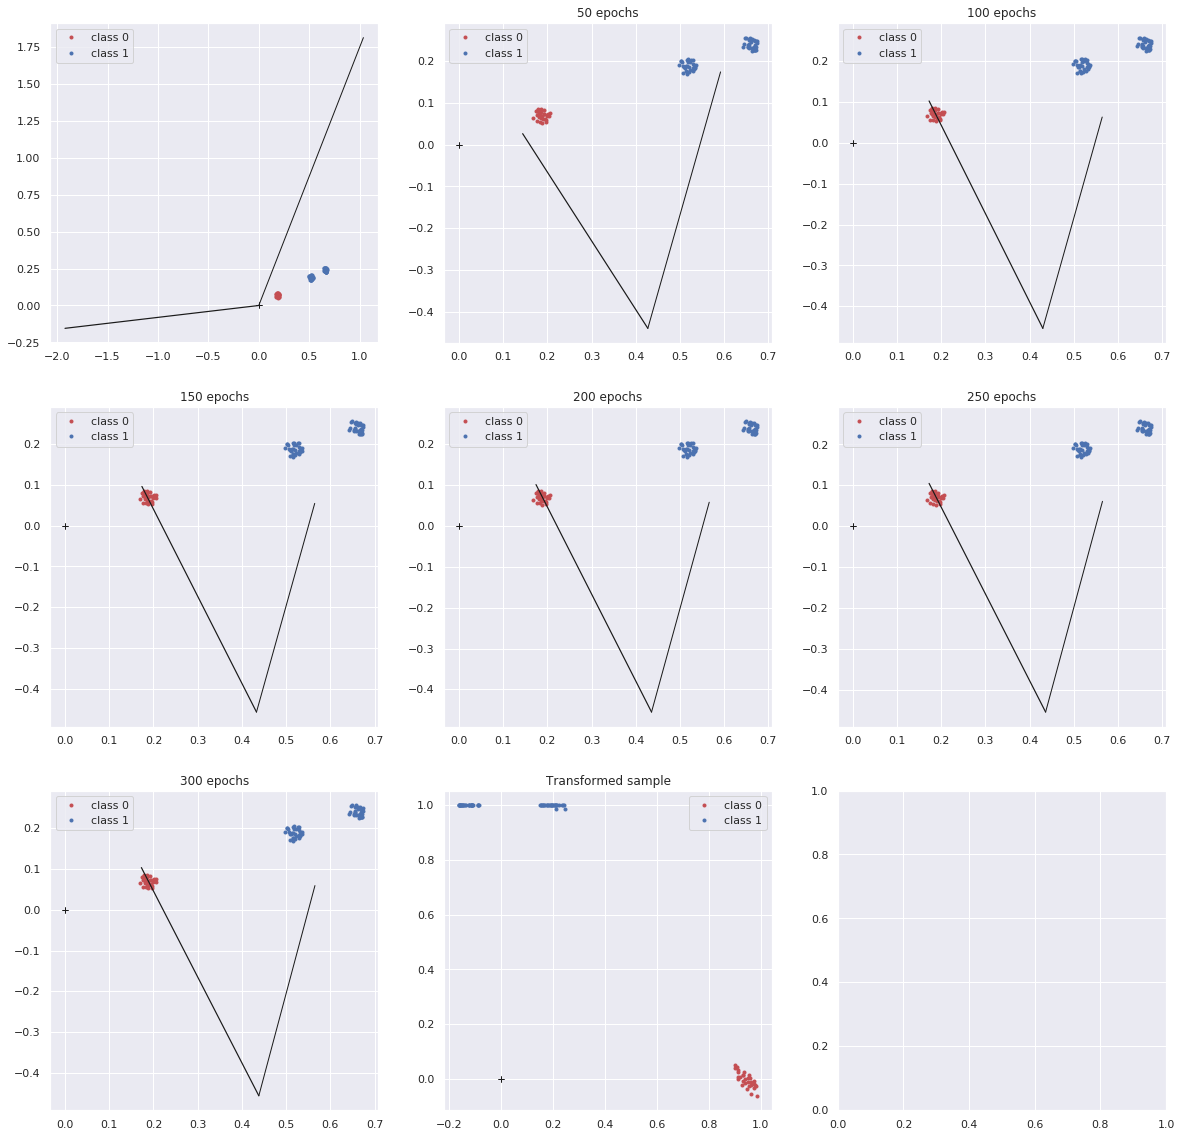

In [39]:

n1 = sn.single_layer(True)
# replace the default bias with our own, zero init
n1.params["b"] =  [n1.pc.add_parameters(2, name='b0', init = np.zeros(2, np.double))]

demonstrate_convergence(train_3patch, nn=n1)

del n1

Now let's see what happens if the labels alternate:

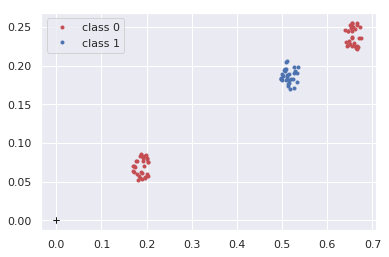

In [41]:

specs = [
    sn.patch_train_data.patch_spec(unit_circle(20*np.pi/180)*0.2,0.02, 30, 0),
    sn.patch_train_data.patch_spec(unit_circle(20*np.pi/180)*0.55,0.02, 30, 1),
    sn.patch_train_data.patch_spec(unit_circle(20*np.pi/180)*0.7,0.02, 30, 0),
]

train_3patch_alt = sn.patch_train_data(specs)

train_3patch_alt.plot()
plt.plot([0,0],[0,0],'k+' )
        
del specs

average loss: 0.556655539988 acc: 0.604222222222
average loss: 0.425335549209 acc: 0.666666666667
average loss: 0.424430941294 acc: 0.666666666667
average loss: 0.42464720099 acc: 0.666666666667
average loss: 0.424485891294 acc: 0.666666666667
average loss: 0.424510135581 acc: 0.666666666667


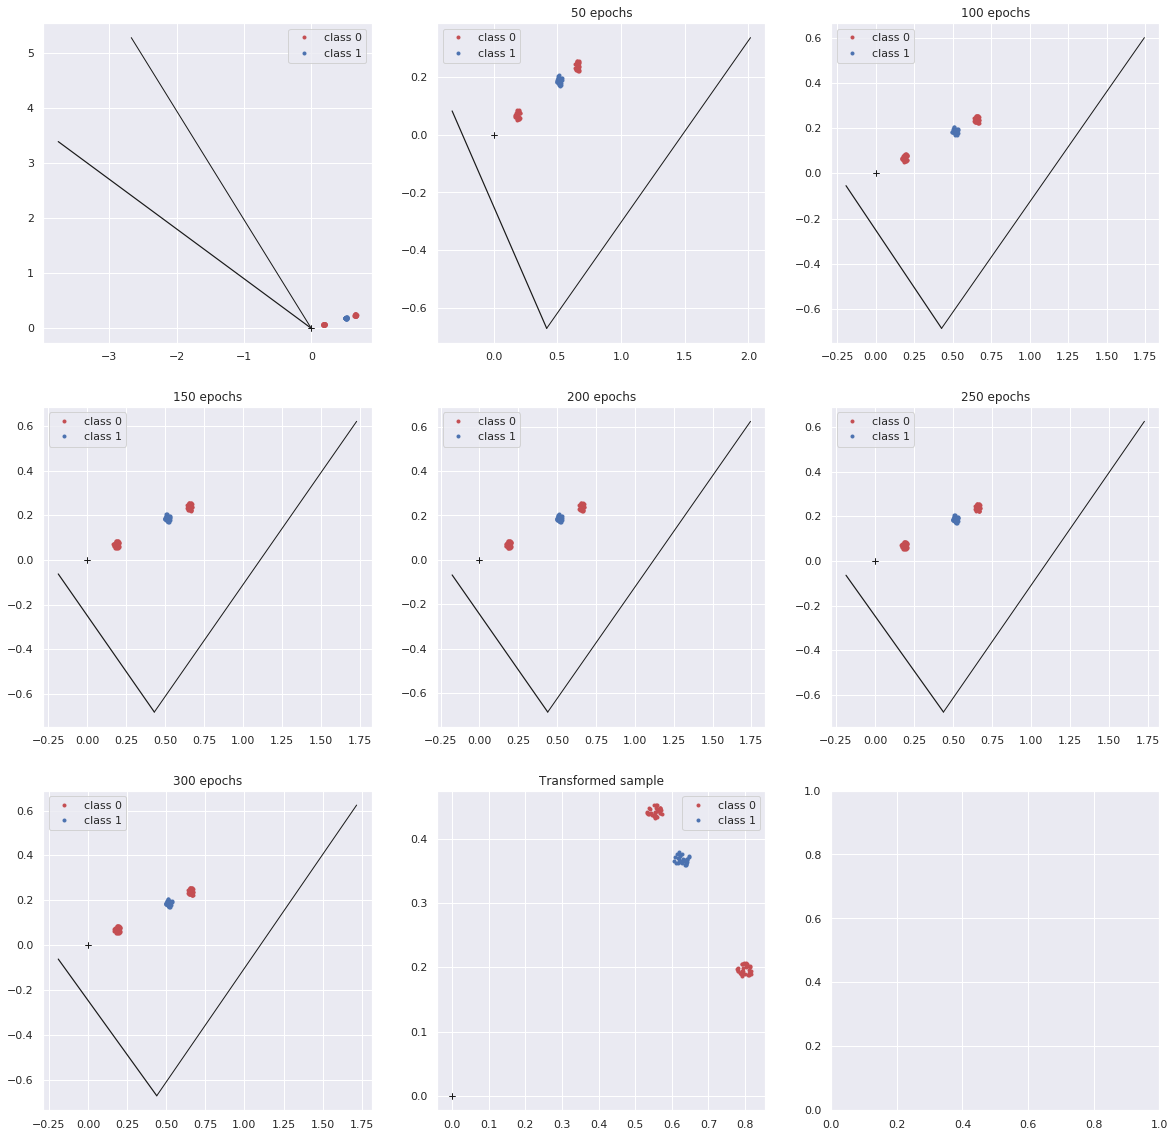

In [44]:

n1 = sn.single_layer(True)
# replace the default bias with our own, zero init
n1.params["b"] =  [n1.pc.add_parameters(2, name='b0', init = np.zeros(2, np.double))]

demonstrate_convergence(train_3patch_alt, nn=n1)

del n1

Ha! no reasonable linear solution. Note the accuracy is $\frac{2}{3}$, due to an entire red patch being mislabeled. In order to improve, there are two things to try:
1. add another layer (or layers)
1. Add another dummy dimension

To be continued..